# Fisher matrix for N-counts (by Domenico Sapone): SOAPFish-release
(August 2019)

##### En este notebook se tiene el análisis para HSC 2000 deg^2, con bin 0.1 < z < 1.4 y masas entre 10^44.2 y 10^45  con delta 0.2( 5 bins). el archivo de z bin llega a 5. Se añade CMB al final.

# Import libraries and ... stuff

In [1]:
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.pyplot as plt
import numpy as np
#import os
import matplotlib.gridspec as gridspec
#from pylab import setp
#import matplotlib.ticker as ticker
import math
import scipy.special as ssp
import scipy.stats as stats

import time
from math import *
import scipy 
import pandas as pd
from scipy import interpolate
from scipy.misc import derivative
import scipy.integrate as integrate

from functools import reduce #python 3
from numpy.linalg import inv
import itertools
#try this for interpolation
from scipy.interpolate import interp1d

#from numba import jit #For C-compilation just in time (requires numba reachable with conda install numba)


interp_type = 'cubic'

dirfiles = 'pks/'
diroutputs = 'Outputs/'


#directory for the specifics
dirspecs = "Inputs/specifics/"

#params for reading input Pks
parin = ['wb','h', 'wm', 'ns']


pow = np.power

# Cosmology

In [2]:
[omegamh2ref,  href, omegabh2ref, nsref, sigma8ref] = [0.022445,  0.67, 0.143648, 0.96, 0.852616]
[omegamref, omegabref] = [omegamh2ref/href**2, omegabh2ref/href**2]


[massivenus, onu, Neff] = [1, 0.00143717, 2.046]

href2 = pow(href,2)

omgref = 0*2.469e-5/href2
omegarref = 0*omgref*(1. + 0.2271*Neff)
omegarh2ref = 0*omegarref*href2

omeganh2ref = onu*href2

omegach2ref = omegamh2ref - omegabh2ref - omeganh2ref;

#this is in km/sec
clight = 299792.458;

# steps for derivatives, for H and Da is larger
eps = 0.01

cosmpar = [omegabh2ref, href, omegamh2ref, nsref]
parin = ['wb','h', 'wm', 'ns']

# Read inputs: survey specifications

In [3]:
extension= 'dat'

klist =  np.loadtxt(dirfiles+'k_values_list.'+extension)
zlist1 = np.loadtxt(dirfiles+'z_values_list.'+extension)

zbin = zlist1[0::2] # es como donde estara centrado el bin
zlist = zlist1[1::2] # los limites del bin (superiores)


In [4]:
zlist

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05,
       1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15,
       2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95, 3.05, 3.15, 3.25,
       3.35, 3.45, 3.55, 3.65, 3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35,
       4.45, 4.55, 4.65, 4.75, 4.85, 4.95])

In [5]:
zlist1

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
       2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
       2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25,
       3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 ,
       3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35,
       4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 ,
       4.95, 5.  ])

In [6]:
zbin

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

In [7]:
# String that it will be useful later when I will call the Pks

zstrign1=[]
for i in range(len(zlist1)):
    if len(str(i))==1:
        zstrign1.append('00'+str(i))
    elif len(str(i))==2:
        zstrign1.append('0'+str(i))
    elif len(str(i))==3:
        zstrign1.append(str(i))

zstrign = zstrign1[1::2]

#fsky = 3/8.;
#volvec = [4*np.pi*pow(180/np.pi,2)*fsky]
#[15469.860468532228]
volvec = [15000];



# Background quantities

In [8]:
#Units of Mpc/h or h/Mpc it's like setting h=1 

def sp(pi, pj):
    if pi==pj: return 1
    else: return 0
    
def hubble(z, h, wm, pi, side):
    if side==1: return 100*h*(1+eps*sp(pi, 1))*np.sqrt(wm*(1+eps*sp(pi, 2))*(1+z)**3/(h*(1+eps*sp(pi, 1)))**2+ 1-wm*(1+eps*sp(pi, 2))/(h*(1+eps*sp(pi, 1)))**2)
    if side==0: return 100*h*np.sqrt(wm*(1+z)**3/(h**2) + 1-wm/(h**2))
    if side==-1: return 100*h*(1-eps*sp(pi, 1))*np.sqrt(wm*(1-eps*sp(pi, 2))*(1+z)**3/(h*(1-eps*sp(pi, 1)))**2+ 1-wm*(1-eps*sp(pi, 2))/(h*(1-eps*sp(pi, 1)))**2)





def int_dcom(z, h, wm, pi, side):
    return clight/hubble(z,h,wm, pi, side)

def dcom0(z, h, wm, pi, side):
    intdcom = scipy.integrate.quad(int_dcom,  0.,  z, args = (h, wm, pi, side))[0]
    return intdcom

dcom = np.vectorize(dcom0)

def da(z, h, wm, pi, side):
    return dcom(z, h, wm, pi, side)/(1+z)


#the volume should not change with the cosmoslogy? 
def volumesurvey(z1, z2, h, wm): #*pow(1,3)
    radtoarea = 4*np.pi/3/(4*np.pi*pow(180/np.pi,2))
    return radtoarea*(pow((1+z2)*da(z2, h, wm, 0, 0),3)-pow((1+z1)*da(z1, h, wm, 0, 0),3))
     
    


def dvol(i, h, wm):
    return volumesurvey(zbin[i], zbin[i+1], h, wm)
        

# Setting some constants useful for N-counts
think whether this should change with the cosmology or not: I'm assuming it does, but for no obvious reasons.

In [9]:
mpckm =  3.086*10**19 #Mpc to km
kmmpc = 1/(3.086*10**19) #km to Mpc


#G is in km**3/kg/sec**2 converted in Mpc**3/kg/sec**2
Gnewton = 6.674*10**(-20.)*kmmpc**3

#clight = 299792.458 #km/sec
def hubconst(h, side):
    #this has units in 1/s
    if side==1: return 100*h*(1+eps)*kmmpc
    elif side==0: return 100*h*kmmpc
    elif side==-1: return 100*h*(1-eps)*kmmpc


def ee(z, h,  wm, pi, side):
    if side==1: return np.sqrt(wm*(1+eps*sp(pi, 2))*(1+z)**3/(h*(1+eps*sp(pi, 1)))**2+ (1-wm*(1+eps*sp(pi, 2)))/(h*(1+eps*sp(pi, 1)))**2)
    if side==0: return np.sqrt(wm*(1+z)**3/(h**2) + 1-wm/(h**2))
    if side==-1: return np.sqrt(wm*(1-eps*sp(pi, 2))*(1+z)**3/(h*(1-eps*sp(pi, 1)))**2+ 1-wm*(1-eps*sp(pi, 2))/(h*(1-eps*sp(pi, 1)))**2)


#scale depending on the mass: it has to be in Mpc as k has units in 1/Mpc
def rm(m, z, h, wm, pi, side):
    #print(hubconst(h, side)*ee(z, h, wm, pi, side))
    return (2*Gnewton*m/(hubconst(h, side)*ee(z, h, wm, pi, side))**2)**(1/3.)


def rhoc(h, side):
    
    #background density of the universe in kg/Mpc**3
    return 3*hubconst(h, side)**2/(8*np.pi*Gnewton)


def rhob(z, h, wm, pi, side):
    if side==1: return rhoc(h, side)*wm*(1+eps*sp(pi, 2))/(h*(1+eps*sp(pi, 1)))**2
    elif side==0: return rhoc(h, side)*wm/h**2
    elif side==-1: return rhoc(h, side)*wm*(1-eps*sp(pi, 2))/(h*(1-eps*sp(pi, 1)))**2



In [10]:
Gnewton

2.270902231868491e-78

# Reading power spectra from CAMB

In [11]:

#Call the Pks and make matrices with interpolated files: faster because info is stored 

# This I need to change from units in h/Mpc to 1/Mpc
def hsr(pi):
    if pi ==1: return href*(1+eps)
    else: return href

def hsl(pi): ######## aqui cambie porque decia pi==1
    if pi ==-1: return href*(1-eps)
    else: return href
    
    


#fiducial Pk
vecintpk = []
for zi in range(len(zstrign)):
    pkfile=np.loadtxt(dirfiles+'fiducial/Pk-fiducial-z_'+str(zstrign[zi])+'.'+extension,skiprows=0)
    s8s=pkfile[1,2]**2
    pks=pkfile[:,1]
    ks=pkfile[:,0]
    interpolpk = scipy.interpolate.interp1d(np.log(ks*href),np.log(s8s*pks/href**3),kind=interp_type,fill_value='extrapolate')
    vecintpk.append(interpolpk)

    
    
#right Pk
vecintpkr = []
for zi in range(len(zstrign)):
    vecintpkr.append([])
    for pi in range(len(parin)):
        pkfiler=np.loadtxt(dirfiles+parin[pi]+'_pl_eps_1p0E-2/Pk-'+parin[pi]+'_pl_eps_1p0E-2-z_'+str(zstrign[zi])+'.'+extension,skiprows=0)
        s8r = pkfiler[1,2]**2
        pksr=pkfiler[:,1]
        ksr=pkfiler[:,0]
        vecintpkr[zi].append(scipy.interpolate.interp1d(np.log(ksr*hsr(pi)),np.log(s8r*pksr/hsr(pi)**3),kind=interp_type,fill_value='extrapolate'))

        
#left Pk
vecintpkl = []
for zi in range(len(zstrign)):
    vecintpkl.append([])
    for pi in range(len(parin)):
        pkfilel=np.loadtxt(dirfiles+parin[pi]+'_mn_eps_1p0E-2/Pk-'+parin[pi]+'_mn_eps_1p0E-2-z_'+str(zstrign[zi])+'.'+extension,skiprows=0)
        s8l = pkfilel[1,2]**2
        pksl=pkfilel[:,1]
        ksl=pkfilel[:,0]
        vecintpkl[zi].append(scipy.interpolate.interp1d(np.log(ksl*hsl(pi)),np.log(s8l*pksl/hsl(pi)**3),kind=interp_type,fill_value='extrapolate'))

   



In [12]:


#interpolation of the fiducial Pks in k
def intpks(zi,k): #DS Takes true k (not an index)
    return np.exp(vecintpk[zi](np.log(k)))

#interpolation of the fiducial log Pks in k
def intlogpks(zi,k): 
    return vecintpk[zi](np.log(k))


#interpolation of the right Pks in k
def intpksr(zi,k, pi): 
    return np.exp(vecintpkr[zi][pi](np.log(k)))

#interpolation of the right log Pks in k
def intlogpksr(zi,k,pi): 
    return vecintpkr[zi][pi](np.log(k))


#interpolation of the left Pks in k
def intpksl(zi, k, pi): 
    return np.exp(vecintpkl[zi][pi](np.log(k)))


#interpolation of the left log Pks in k                  
def intlogpksl(zi,k,pi): 
    return vecintpkl[zi][pi](np.log(k))



# Testing the Pk evaluated by CAMB and the growth factor defined

# Evaluating the rms density fluctuations 

\begin{equation}
        \sigma^2(M,z)= \frac{1}{2\pi^2}\int_{k_{\rm m}}^{k_{\rm M}} k^2 P(k,z)W^2(k\,R(M)){\rm d}k
\end{equation}
we do not use the growth factor $G(z)$ but we let the $P(k)$ vary with $z$ and 
\begin{eqnarray}
        W(x) &=& \frac{3}{x^3}\left(\sin(x)-x\,\cos(x)\right)\\
        R(M) &=& \left(\frac{3 M}{4\pi \rho_b(z)}\right)^{1/3}\\
\end{eqnarray}
and a new variable was defined to be
\begin{equation}
\nu = \delta_c/\sigma(M,z)
\end{equation}
being $\delta_c = 1.686$

In [13]:
#defining the top-hat filter
def window(x):
    return 3.0*(np.sin(x)-x*np.cos(x))/x**3.


kminint = 0.001
kmaxint = 5.




#For the moment I don't need the growth factor because the Pk have been evaluated at different z
# which means they've been properly evaluated
def intwind(k, zi,  m, h, wm, pi, side):
    if side==1:
        return k**2*intpksr(zi,k, pi)*window(k*rm(m, zlist[zi], h, wm, pi, side))**2
    elif side == 0: return k**2*intpks(zi,k)*window(k*rm(m, zlist[zi], h, wm, pi, side))**2
    elif side == -1: return k**2*intpksl(zi,k, pi)*window(k*rm(m, zlist[zi], h, wm, pi, side))**2
    
    


def smfunc(zi, m, h, wm, pi, side):
    kgrid = np.linspace(np.log(0.001), np.log(5), 2**8+1)
    #print(kgrid)
    dk = np.diff(kgrid)[0]
    #print('parameters:', zi, m, h, wm, pi, side)
    #print(intwind(np.exp(kgrid), zi,  m, h, wm, pi, side))
    intwind1 = intwind(np.exp(kgrid), zi,  m, h, wm, pi, side)*np.exp(kgrid)
    #print(intwind1)
    #I1 = np.cumsum(dk*intwind1)
    I1 =  scipy.integrate.romb(intwind1, dx=dk)
    return np.sqrt(I1/(2*pow(np.pi,2)))



def lnsmfunc(zi, m, h, wm, pi, side):
    kgrid = np.linspace(np.log(0.001), np.log(5), 2**8+1)
    dk = np.diff(kgrid)[0]
    intwind1 = intwind(np.exp(kgrid), zi,  m, h, wm, pi, side)*np.exp(kgrid)
    I1 =  scipy.integrate.romb(intwind1, dx=dk)
    return np.log(np.sqrt(I1/(2*pow(np.pi,2))))





# nu = log(d_c/sigma)
def invlnsmfunc(zi, m, h, wm, pi, side):
    dc = 1.686
    return np.log(dc/smfunc(zi, m, h, wm, pi, side))





# dln\sigma**-1/dlnM
def dlninvsdlnm(zi, m, h, wm, pi, side):
   
    dright = invlnsmfunc(zi, m**(1+eps), h, wm, pi, side)
    dleft = invlnsmfunc(zi, m**(1-eps), h, wm, pi, side)
    #lnm = np.log(m)
    return (dright-dleft)/(2*eps*np.log(np.float(m)))
 
    

# dln\sigma**-1/dM
def dlninvsdm(zi, m, h, wm, pi, side):
   
    dright = invlnsmfunc(zi, m*(1+eps), h, wm, pi, side)
    dleft = invlnsmfunc(zi, m*(1-eps), h, wm, pi, side)
    #lnm = np.log(m)
    return (dright-dleft)/(2*eps*m)
    
    
# d\nu/dM
def dnudm(zi, m, h, wm, pi, side):
    dc = 1.686
    #print(smfunc(zi, m*(1+eps), h, wm, pi, side))
    nuright = dc/smfunc(zi, m*(1+eps), h, wm, pi, side)
    nuleft = dc/smfunc(zi, m*(1-eps), h, wm, pi, side)
   
    return (nuright-nuleft)/(2*eps*m)
    


# Some tests

In [14]:
solar_mass = 2*10**30.
init_mass = 10**14.
fin_mass = 10**16.


expmass = np.arange(np.log10(solar_mass*init_mass), np.log10(solar_mass*fin_mass), 0.2)
v_dlninvsdlnm = []
for i in range(len(expmass)):
    v_dlninvsdlnm.append(dlninvsdlnm(1, 10**expmass[i], href, omegamh2ref, 0, 0))

In [15]:
np.arange(np.log10(solar_mass*init_mass), np.log10(solar_mass*fin_mass), 0.2)

array([44.30103, 44.50103, 44.70103, 44.90103, 45.10103, 45.30103,
       45.50103, 45.70103, 45.90103, 46.10103])

# Mass function for cluster; taken from: arXiv:0005260

Sheth Thormen mass function is
\begin{equation}
\frac{dn_{\rm ST}}{d\ln
M}=\frac{\bar{\rho}}{M}\nu\frac{d\ln\nu}{d\ln M} f_{ST}(\nu) = \bar{\rho}\frac{d\nu}{d M} f_{ST}(\nu)\,,
\end{equation}
where 
\begin{equation}
f_{ST}(\nu) = A\sqrt{\frac{2a}{\pi}}\left(1+\frac{1}{(\sqrt{a}\nu)^{2q}}\right)a\exp\left(-\frac{(\sqrt{a}\nu)^2}{2}\right)
\end{equation}
with $A=0.3222$, $a=0.707$, and $q=0.3.$ 

The constants and the form of the collapse threshold are adjusted somewhat using calibrations from cosmological simulations of structure formation. For this reason, this function is a pretty accurate  representation of the mass function of collapsed halos in cosmological simulations. It is accurate to better than $30\%$ over galaxy scale masses and has larger error at large masses. 

In [16]:
# Sheth-Tormen differential mass function     
def stfun1(zi, m, h, wm, pi, side):
    capa = 0.322
    a= 0.707
    q = 0.3
    dc = 1.686
    nu = dc/smfunc(zi, m, h, wm, pi, side)
    return capa*a*np.sqrt(2/np.pi)*(1+1/(a*nu)**(2**q))*np.exp(-(a*nu)**2/2)


#Sheth, Mo & Tormen 2001
def stfun(zi, m, h, wm, pi, side):
    capa = 0.322
    a= 0.707
    q = 0.3
    dc = 1.686
    nu = dc/smfunc(zi, m, h, wm, pi, side)
    return capa*np.sqrt(2*a/np.pi)*(1+1/(a*nu**2)**(q))*np.exp(-a/2*nu**2)



# Sheth-Tormen differential mass function to plot as a function of sigma
def stfun_toplot(zi, m, h, wm, sig):
    capa = 0.322
    a= 0.707
    q = 0.3
    dc = 1.686
    nu = dc/sig
    return capa*np.sqrt(2*a/np.pi)*(1+1/(a*nu**2)**(q))*np.exp(-(a*nu**2)/2)




#this is - dn/dM
def dndm_st(zi, m, h, wm, pi, side):
    # using Sheth and Tormen 
    # the units number/Volume but I need to express it in Mpc, hence
    # I need to convert it dividing it by kmmpc**3 factor 
    return rhob(zlist[zi], h, wm, pi, side)/m*dnudm(zi, m, h, wm, pi, side)*stfun(zi, m, h, wm, pi, side)#/kmmpc**3



In [17]:
dndm_st(1, 10**45., href, omegamh2ref, 1, 0)

5.872487136766182e-52

In [18]:
def toplot_dndm(pi, side):
    expmass = np.arange(13.5, 15.3, 0.2)
    v_logdndlnm_st = []
    for i in range(len(expmass)):
        v_logdndlnm_st.append(np.log10(dndm_st(1, 2*10**30*10**expmass[i], href, omegamh2ref, pi, side)*(2*10**30*10**expmass[i])))
    return np.array(v_logdndlnm_st)
        
        
        

In [19]:
def der_toplot_dndm(pi):
    return (toplot_dndm(pi, 1)-toplot_dndm(pi, -1))/(2*eps*cosmpar[pi]*toplot_dndm(pi, 0))
    

In [20]:
expmass1 = np.arange(13., 18.5, 0.3)

def v_dndlnm_st_z(z, pi, side):
    v_dndlnm_st = []
    for i in range(len(expmass1)):
        v_dndlnm_st.append(href**-3*dndm_st(z, solar_mass*10**expmass1[i], href, omegamh2ref, pi, side)*solar_mass*10**expmass1[i])
    return np.array(v_dndlnm_st)


# Average number density of clusters

\begin{equation}
n_i = \int_{z_{min}}^{z_{max}}{\rm d}z\frac{\chi^2(z)}{H(z)}\int_{M_{\rm min}}^{M_{\rm max}} \frac{{\rm d}M}{M}\frac{{\rm d}n}{{\rm d}\ln M}\times
    \frac{1}{2} \left[erfc(x_i)-erfc(x_{i+1})\right]\theta(z-z_{min})\theta(z_{max}-z)
\end{equation}
or 
\begin{equation}
n_i = \int_{z_{min}}^{z_{max}}{\rm d}z\frac{\chi^2(z)}{H(z)}\int_{M_{\rm min}}^{M_{\rm max}} {\rm d}M\frac{{\rm d}n}{{\rm d}M}\times
    \frac{1}{2} \left[erfc(x_i)-erfc(x_{i+1})\right]\theta(z-z_{min})\theta(z_{max}-z)
\end{equation}
where $erfc$ is the complementary error function, and 
\begin{equation}
x\left(M^{obs}\right) = \frac{\ln M^{obs}-\ln M - \ln M^{bias}}{\sqrt{2\sigma_{\ln M}^{2}}}
\end{equation}
Assumptions: $\ln M^{bias}=0$ and $\sigma_{\ln M}= 0.3$
We also define, for sake of simplicity, the quantity
\begin{equation}
S_{i(b)}(z) = \frac{1}{2} \left[erfc(x_i)-erfc(x_{i+1})\right]\theta(z-z_{min})\theta(z_{max}-z)
\end{equation}
which is a sort of a filter in z bin and Mass bin

In [21]:
from scipy import special

def x(mobs, m):
    sigmam = 0.3
    return (np.log(mobs)-np.log(m))/np.sqrt(2*sigmam**2)


def integnmean1(m, z, mobs, zi, h, wm, pi, side):
    sigmam = 0.3
    heavy = np.heaviside(z-zbin[zi], 1)*np.heaviside(zbin[zi+1]-z, 1)
    erfi = (special.erfc(x(mobs, m))-special.erfc(x(mobs*(1+np.exp(sigmam)), m)))*1/2
    vol_term = clight*dcom(z, h, wm, pi, side)**2/hubble(z, h, wm, pi, side)
    return vol_term*heavy*erfi*dndm_st(zi, m, h, wm, pi, side)

integnmean = np.vectorize(integnmean1)


#average number density of clusters
#def nmean_old(zi, mobs, h, wm, pi, side, delm):
#    mminint = mobs #*10**(-delm)
#    mmaxint = mobs*10**(+delm)
#    
#    zmin = zbin[zi]
#    zmax = zbin[zi+1]
#
#    integ = integrate.dblquad(integnmean1, zmin, zmax, lambda x: mminint, lambda x: mmaxint, args = (mobs,  zi, h, wm, pi, side))[0]
#    return integ

def integrate2D(dfun, zgrid, lellgrid):
    
    muint = [scipy.integrate.romb(dfun.T[i], dx=np.diff(lellgrid)[0]) for i in range(zgrid.size)]
    return scipy.integrate.romb(muint, dx=np.diff(zgrid)[0])


#average number density of clusters
# much faster, it needs since it has to be done in a small window, 
# we can choose small number of subdivision, error of 1e-4% with respect to the full integration
def nmean1(zi, mobs, h, wm, pi, side, delm):
    mminint = mobs*10**(-delm)
    mmaxint = mobs*10**(+delm)
    
    zmin = zbin[zi]
    zmax = zbin[zi+1]
  
    
    zgrid = np.linspace(zmin,zmax, 2**2+1) 
    massgrid = np.linspace(np.log10(mminint), np.log10(mmaxint), 2**3+1)
    m, z = np.meshgrid(massgrid, zgrid)
    return integrate2D(np.log(10)*10**m*integnmean(10**m, z, mobs, zi, h, wm, pi, side), massgrid, zgrid)

nmean = np.vectorize(nmean1)


In [22]:
x

<function __main__.x>

In [23]:
import time
start_time = time.time()
print(nmean([0,0], [10**45.,10**45.5], href, omegamh2ref, 2, 0, 0.3))
print(time.time() - start_time)

start_time = time.time()
for i in [0,0]:
    print(nmean(i, [10**45.,10**45.5], href, omegamh2ref, 2, 0, 0.3))
print(time.time() - start_time)

[9.14546713 1.57921514]
0.111312150955
[9.14546713 1.57921514]
[9.14546713 1.57921514]
0.206649065018


# Plotting tot N counts as a function of Mass and per z bin

In [24]:

ztest = np.array([0, 3, 5, 9])
vectnmean = []
def vectnmean_f(pi, side):
    for j in range(len(ztest)):
        vectnmean.append([])
        for i in range(len(expmass)):
            vectnmean[j].append(nmean(ztest[j], 10**expmass[i], href, omegamh2ref, pi, side, 0.5))
    return vectnmean

In [25]:
expmass = np.array([44, 44.3, 45., 45.3, 46., 46.3])

def vectnmean_fz(z, pi, side):
    vectnmean = []
    for i in range(len(expmass)):
        vectnmean.append(nmean(z, 10**expmass[i], href, omegamh2ref, pi, side, 0.5))
    return vectnmean

# Defining the tot number counts as a function of z

In [26]:
#def nmeanz_1(z, mobs,  zi, h, wm, pi, side, delm):
#    mminint = mobs #*10**(-delm)
#    mmaxint = mobs*10**(+delm)
    
#    
#    integz = scipy.integrate.quad(integnmean,  mminint,  mmaxint, args = (z, mobs, zi, h, wm, pi, side))[0]
#    return integz





In [27]:
def nmeanz(z, mobs,  zi, h, wm, pi, side, delm):
    mminint = mobs*10**(-delm)
    mmaxint = mobs*10**(+delm)
    massgrid = np.linspace(np.log10(mminint), np.log10(mmaxint), 2**3+1)
    integz = scipy.integrate.romb(np.log(10)*10**massgrid*integnmean(10**massgrid, z, mobs, zi, h, wm, pi, side), dx=np.diff(massgrid)[0])
    return integz


def vectnmean_fzz(mm, pi, side):
    vectnmeanz = []
    for i in range(len(zlist)-1):
        vectnmeanz.append(nmeanz(zlist[i],  10**mm, i, href, omegamh2ref, pi, side, 0.5))
    return vectnmeanz

# Define halo bias

For which we use the Sheth&Tormen, although new fits exist
\begin{equation}
b_{\rm ST} = 1+\frac{a\nu - 1}{\delta_c}+\frac{2p/\delta_c}{1+(a\nu)^p}
\end{equation}
$a=0.707$, and $p=0.3.$ and $\nu = (\delta_c/\sigma)^2$.
Moreover, the window function entering in the fisher matrix is 
\begin{equation}
W_{i(b)}^h(z) = \frac{1}{n_i}\frac{\chi^2(z)}{H(z)}\int{\rm d}M \frac{{\rm d}n}{{\rm d}M}S_{i(b)}(z)b_{\rm ST}(N,z) = 
\frac{1}{n_i}\frac{\chi^2(z)}{H(z)}\bar{W}_{i(b)}^h(z)
\end{equation}



In [28]:
def halo_bias(zi, m, h, wm, pi, side):
    a= 0.707
    p = 0.3
    dc = 1.686
    nu = dc/smfunc(zi, m, h, wm, pi, side)
    return 1+(a*nu**2-1)/dc+2*p/dc/(1+(a*nu**2)**p)



def window_h_int(m, z, zi,  mobs, h, wm, pi, side):
    sigmam = 0.3
    heavy = np.heaviside(z-zbin[zi], 1)*np.heaviside(zbin[zi+1]-z, 1)
    erfi = (special.erfc(x(mobs, m))-special.erfc(x(mobs*(1+np.exp(sigmam)), m)))*1/2
    integnmean = erfi*dndm_st(zi, m, h, wm, pi, side)*halo_bias(zi, m, h, wm, pi, side)
   
    return integnmean


#CHECK THIS PLEASE, the delm

def window_h1(z, zi, mobs, h, wm, delm, pi, side):
    
    mminint = mobs*10**(-delm)
    mmaxint = mobs*10**(+delm)

    intwind_h = scipy.integrate.quad(window_h_int,  mminint,  mmaxint, args = (z, zi, mobs, h, wm, pi, side))[0]
    return intwind_h

window_h = np.vectorize(window_h1)



In [29]:
window_h(0.07, 0, 10**45., href, omegamref, 0.2, 0, 0)
#window_h_int(10**45, 0.07, 0, 10**45, href, omegamref, 0, 0)
#x(10**45., 10**45.)

array(1.06930808e-06)

In [30]:
7.18019564e-07

7.18019564e-07

In [31]:
zlist
omegamref
np.log(10**10)

23.025850929940457

# The covariance matrix

The covariance matrix, to be used in the Fisher matrix is 
\begin{equation}
{\rm cov}(N_{i(b)},N_{j(b')}) = N_{i(b)}\delta_{i,j}\delta_{bb'}+S_{i(bb')}\delta_{ij}
\end{equation}
where $i$ and $j$ run over the redshift bins, whereas $b$ and $b'$ over the masses. The function $N_{i(b)}= \Omega_s n_i$, being $\Omega_s $ the survey angle (in deg2). 

The $S_{i(bb')}$ is 
\begin{eqnarray}
S_{i(bb')} &=& \Omega_{s}^2n_i n_j \int\frac{{\rm d}\chi(z)}{\chi^2(z)}W_{i(b)}^h(z) W_{i(b')}^h(z)\int\frac{\ell {\rm d}\ell}{2\pi}\left|\tilde{W}_s(\ell \Theta_s)\right|^2 P\left(k = \frac{\ell}{\chi(z)},z\right)\\
&=& \Omega_{s}^2n_i n_j \int{\rm d}z\frac{\chi^2(z)}{H^2(z)}\frac{1}{n_i n_j}\bar{W}_{i(b)}^h(z) \bar{W}_{i(b')}^h(z)\int\frac{\ell {\rm d}\ell}{2\pi}\left|\tilde{W}_s(\ell \Theta_s)\right|^2 P\left(k = \frac{\ell}{\chi(z)},z\right)
\end{eqnarray}
where 
\begin{equation}
\tilde{W}_s(\ell \Theta_s) = \frac{2J_i(\ell \Theta_s)}{\ell \Theta_s}
\end{equation}
being $J_1$ the spherical Bessel kind and $\Theta_s$ the area of the survey in steradiants  

In [32]:
def wind_bessel1(ell, thetas):
    spher = scipy.special.spherical_jn(1, ell*thetas, derivative=False)
    return np.abs(2*spher/(ell*thetas))
wind_bessel = np.vectorize(wind_bessel1)

Let us assume for the moment the $n_i$ is mildly dependent on z, hence
\begin{equation}
S_{i(bb')} = \Omega_{s}^2  \int{\rm d}z\frac{\chi^2(z)}{H^2(z)}\bar{W}_{i(b)}^h(z) \bar{W}_{i(b')}^h(z)\int\frac{\ell {\rm d}\ell}{2\pi}\left|\tilde{W}_s(\ell \Theta_s)\right|^2 P\left(k = \frac{\ell}{\chi(z)},z\right)
\end{equation}
Apparently there is no difference: does it mean we can take $n_i$ and $n_j$ out from the calculation? As above?
Or do we need to check what the limit of integration in $z$ from the previous step are?

In [33]:
def ps_for_ess(zi, k, pi, side):
    if side==1: return intpksr(zi,k, pi)
    elif side == 0: return intpks(zi,k)
    elif side == -1: return intpksl(zi,k, pi)
    


#without nmean included
def int_ess(z, lell, zi, zj, mobs, mobs1, h, wm, delm, pi, side):
    thetas = 4*np.pi
    omegas = 2000
    winds= window_h(z, zi, mobs, h, wm, delm, pi, side)*window_h(z, zj, mobs1, h, wm, delm, pi, side)
    volt = (dcom(z, h, wm, pi, side)/hubble(z,h,wm,pi, side))**2
    wind_b = wind_bessel(10**lell, thetas)**2
    pk = ps_for_ess(zi, 10**lell/dcom(z,h,wm, pi, side), pi, side)
    return omegas**2*volt*winds*wind_b*pk*10**(2*lell)/(2*np.pi)




#with nmean included
def int_ess_full(z, lell, zi, zj, mobs, mobs1, h, wm, delm, pi, side):
    thetas = 4*np.pi
    omegas = 2000
    winds= window_h(z, zi, mobs, h, wm, delm, pi, side)*window_h(z, zj, mobs1, h, wm, delm, pi, side)
    volt = (dcom(z, h, wm, pi, side)/hubble(z,h,wm,pi, side))**2
    wind_b = wind_bessel(10**lell, thetas)**2
    pk = ps_for_ess(zi, 10**lell/dcom(z,h,wm, pi, side), pi, side)
    ratio_nmean = 1/(nmean(zi, mobs, h, wm, pi, side, delm)*nmean(zj, mobs1, h, wm, pi, side, delm))
    return ratio_nmean*omegas**2*volt*winds*wind_b*pk*10**(2*lell)/(2*np.pi)



def integrate2D(dfun, zgrid, lellgrid):
    
    muint = [scipy.integrate.romb(dfun.T[i], dx=np.diff(lellgrid)[0]) for i in range(zgrid.size)]
    return scipy.integrate.romb(muint, dx=np.diff(zgrid)[0])



def ess_func(zi, zj, mobs, mobs1, h, wm, delm, pi, side):
    ellmin = np.log10(8)
    ellmax = np.log10(10000)
    zmin = zlist[0]
    zmax = zlist[-1]
    
    zgrid = np.linspace(zlist[0], 2., 2**4+1) 
    lellgrid = np.linspace(np.log10(8), np.log10(10000), 2**4+1)
    z, lell = np.meshgrid(zgrid, lellgrid)

    return integrate2D(int_ess(z, lell, zi, zj, mobs, mobs1, h, wm, delm, pi, side),zgrid, lellgrid)
    
    


def ess_func_full(zi, zj, mobs, mobs1, h, wm, delm, pi, side):
    ellmin = np.log10(8)
    ellmax = np.log10(10000)
    zmin = zlist[0]
    zmax = zlist[-1]
    
    zgrid = np.linspace(zlist[0], 2., 2**4+1) 
    lellgrid = np.linspace(np.log10(8), np.log10(10000), 2**4+1)
    z, lell = np.meshgrid(zgrid, lellgrid)

    return nmean(zi, mobs, h, wm, pi, side, delm)*nmean(zj, mobs1, h, wm, pi, side, delm)*integrate2D(int_ess_full(z, lell, zi, zj, mobs, mobs1, h, wm, delm, pi, side),zgrid, lellgrid)
    
    
    

# Bulding the Cov matrix

###### aqui te da los elementos de la matriz de covarianza, no la matriz completa asi que hay que construirla

In [34]:
def krone(ii, jj):
    if ii==jj: return 1
    else: return 0


#def cov_mat(zi, zj, mobs, mobs1, h, wm, delm, pi, side):
#    omegas = 20000
#    n_cov= omegas*nmean(zi, mobs, h, wm, pi, side, delm)
#    s_cov = ess_func_full(zi, zj, mobs, mobs1, h, wm, delm, pi, side)
#    return n_cov*krone(zi, zj)*krone(mobs, mobs)+s_cov*krone(zi, zj)

def cov_mat(zi, zj, mobs, mobs1, h, wm, delm, pi, side):
    omegas = 2000
    if zi==zj and mobs==mobs1:
        n_cov=omegas*nmean(zi, mobs, h, wm, pi, side, delm)
    elif zi!=zj or mobs!=mobs1:
        n_cov=0
        
    s_cov = ess_func_full(zi, zj, mobs, mobs1, h, wm, delm, pi, side)
    return n_cov+s_cov*krone(zi, zj)
    

In [35]:
cov_mat1=np.vectorize(cov_mat)

### Creando la matriz de covarianza

In [36]:
from multiprocessing import Pool
import multiprocessing
from numpy import array

##### Investigando donde obtengo mas ganancias de funcion nmean

In [37]:
start_time = time.time()

values=[]

#for zi in binz1:
def fullmatrix_perz(zi):
    values=[]
    print('zi',zi)
    for j in range(len(binm)):
        b=binm[j]
        a1=a1=np.tile(binz[0],len(binm))
        a1=list(a1)
        print(j,'b = ',b)
        cov1=cov_mat1(zi,a1,b,binm, href, omegamh2ref, 0.1, 6, 0)
        for i in range(1,len(binz)):
            a1=np.tile(binz[i],len(binm))
            a1=list(a1)
            cov2=cov_mat1(zi,a1,b,binm, href, omegamh2ref, 0.1, 6, 0)
            cov1=np.hstack((cov1,cov2))
        values.append(cov1)

    print(time.time()-start_time)
    return values

In [38]:

expmass=np.arange(44.2,45.2,0.2)

binm=10**expmass
binz=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]

In [39]:
binm

array([1.58489319e+44, 2.51188643e+44, 3.98107171e+44, 6.30957344e+44,
       1.00000000e+45])

In [40]:
p = multiprocessing.Pool()

resultado = (p.map(fullmatrix_perz,binz))
print resultado
print(time.time()-start_time)

('zi', 2)
('zi', 4)
('zi', 5)
('zi', 3)
('zi', 1)
('zi', 10)
('zi', 7)
('zi', 9)
('zi', 12)
('zi', 8)
('zi', 6)
(0, 'b = ', 1.5848931924611238e+44)
('zi', 11)
(0, 'b = ', 1.5848931924611238e+44)
(0, 'b = ', 1.5848931924611238e+44)
(0, 'b = ', 1.5848931924611238e+44)
(0, 'b = ', 1.5848931924611238e+44)
(0, 'b = ', 1.5848931924611238e+44)
(0, 'b = ', 1.5848931924611238e+44)
(0, 'b = ', 1.5848931924611238e+44)
(0, 'b = ', 1.5848931924611238e+44)
(0, 'b = ', 1.5848931924611238e+44)
(0, 'b = ', 1.5848931924611238e+44)
(0, 'b = ', 1.5848931924611238e+44)
(1, 'b = ', 2.511886431509613e+44)
(1, 'b = ', 2.511886431509613e+44)
(1, 'b = ', 2.511886431509613e+44)
(1, 'b = ', 2.511886431509613e+44)
(1, 'b = ', 2.511886431509613e+44)
(1, 'b = ', 2.511886431509613e+44)
(1, 'b = ', 2.511886431509613e+44)
(1, 'b = ', 2.511886431509613e+44)
(1, 'b = ', 2.511886431509613e+44)
(1, 'b = ', 2.511886431509613e+44)
(1, 'b = ', 2.511886431509613e+44)
(1, 'b = ', 2.511886431509613e+44)
(2, 'b = ', 3.98107170553

In [41]:
matriz_cov=[]
for i in resultado:
    for j in i:
        matriz_cov.append(j)

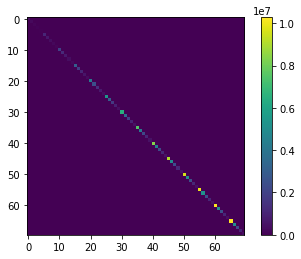

In [42]:
plt.imshow(matriz_cov)
plt.colorbar()
plt.show()

In [43]:
matrix_cov_matrix = np.matrix(matriz_cov)

In [44]:
np.shape(matrix_cov_matrix)

(70, 70)

Antes de hacer la inversa necesito sacar los nan.

In [46]:
df = pd.DataFrame(matrix_cov_matrix)
df

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,423702.889495,0.012032,0.008171,0.005435,0.003501,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
1,0.012032,263431.419908,0.005621,0.003739,0.002408,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
2,0.008171,0.005621,159533.375446,0.002539,0.001635,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
3,0.005435,0.003739,0.002539,93291.604950,0.001088,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
4,0.003501,0.002408,0.001635,0.001088,52061.482882,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.091169e+06,0.011287,0.007579,0.004963,0.003130,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,1.128749e-02,669656.327667,0.005171,0.003386,0.002136,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,7.578615e-03,0.005171,399086.021924,0.002274,0.001434,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,4.962642e-03,0.003386,0.002274,228761.779399,0.000939,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,3.129999e-03,0.002136,0.001434,0.000939,124503.594428,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000


### Inviertiendo la matriz de covarianza

In [47]:
inversa_cov = inv(matrix_cov_matrix)

Ahora la inversa debo dejarla en un formato easy to read for a function.
Arreglando la inversa:

In [48]:
largoz=len(binz)
largom=len(binm)
print(largoz,largom)
num=largom
rangos = np.arange(0,largoz*largom,largom)
print(rangos)

new_inverted=[]

inversa_splitted = np.split(np.array(inversa_cov),largoz)

for i in range(largoz):
    lista_por_line=[]
    for j in rangos:
        matrix1 = np.array(inversa_splitted[i])[:,j:j+num]
        lista_por_line.append(matrix1)
    new_inverted.append(lista_por_line)


(14, 5)
[ 0  5 10 15 20 25 30 35 40 45 50 55 60 65]


# The Fisher matrix

\begin{equation}
F_{\alpha\beta} = \sum_{I, J}\frac{\partial N_I}{\partial p_\alpha}\left[{\rm cov}(N,N)\right]^{-1}_{I,J}\frac{\partial N_J}{\partial p_\beta}
\end{equation}
where:
$I$ and $J$ run over the redshift bins and mass bins and they have to be decided according to one possible survey. 

$\alpha$ and $\beta$ run over the number of parameter (in this case 4 but we can decide the parameters we want)

Hence the cov matrix should be a matrix $n\times n$, where n is the number of the z bins, whose elements are matrices of $m\times m$, where $m$ is the number of mass bin. 

In [49]:
parin = ['wb','h', 'wm', 'ns']
nparams=len(parin)
cosmpar = [omegabh2ref, href, omegamh2ref, nsref]
indices_pi = [0, 1, 2, 3]

In [50]:
delm=0.1

start_time = time.time()

fishermatrix=[]

for i in range(nparams):
    print('Corrida 1: Indice, parametro y nombre del parametro: ', indices_pi[i],cosmpar[i], parin[i])
    matrix2=[]
    for j in range(nparams):
        suma=0
        for zi in range(len(binz)):
            for zj in range(len(binz)):
                ni_p = nmean(binz[zi], binm, href, omegamh2ref, indices_pi[i], 1, delm)
                ni_m = nmean(binz[zi], binm, href, omegamh2ref, indices_pi[i], -1, delm)
                invcov = new_inverted[zi][zj]
                nj_p = nmean(binz[zj], binm, href, omegamh2ref, indices_pi[j], 1, delm)
                nj_m = nmean(binz[zj], binm, href, omegamh2ref, indices_pi[j], -1, delm)
                derivative =  (ni_p - ni_m)/(2*eps*cosmpar[i])
                derivative2 = (nj_p - nj_m)/(2*eps*cosmpar[j])
                derivative = np.matrix(derivative)
                derivative2 =np.matrix(derivative2)
                fish = np.dot(derivative,np.dot(invcov,derivative2.T))
                suma=suma+fish
        matrix2.append(suma)
    fishermatrix.append(matrix2)

print('Fisher time: ',time.time() - start_time)
df = pd.DataFrame(fishermatrix, columns = parin, index=parin)
print('Fisher Matrix')
print(df)

('Corrida 1: Indice, parametro y nombre del parametro: ', 0, 0.143648, 'wb')
('Corrida 1: Indice, parametro y nombre del parametro: ', 1, 0.67, 'h')
('Corrida 1: Indice, parametro y nombre del parametro: ', 2, 0.022445, 'wm')
('Corrida 1: Indice, parametro y nombre del parametro: ', 3, 0.96, 'ns')
('Fisher time: ', 2589.463604927063)
Fisher Matrix
                            wb                          h  \
wb   [[[[[451679.70834882]]]]]   [[[[[72278.82423907]]]]]   
h     [[[[[72278.82423907]]]]]   [[[[[11963.70901801]]]]]   
wm  [[[[[3651572.12779827]]]]]  [[[[[580537.78183185]]]]]   
ns    [[[[[82518.16519318]]]]]   [[[[[13137.61690417]]]]]   

                             wm                        ns  
wb   [[[[[3651572.12779827]]]]]  [[[[[82518.16519318]]]]]  
h     [[[[[580537.78183185]]]]]  [[[[[13137.61690417]]]]]  
wm  [[[[[29568218.27760895]]]]]   [[[[[668117.289072]]]]]  
ns      [[[[[668117.289072]]]]]  [[[[[15099.00508025]]]]]  


In [51]:
df1 = df.astype(float)
df1

,wb,h,wm,ns
wb,4.516797e+05,72278.824239,3.651572e+06,82518.165193
h,7.227882e+04,11963.709018,5.805378e+05,13137.616904
wm,3.651572e+06,580537.781832,2.956822e+07,668117.289072
ns,8.251817e+04,13137.616904,6.681173e+05,15099.005080


###### \begin{equation} \sigma_{i} =\sqrt{F^{-1}_{ii}}\end{equation}

In [52]:
print(df1)
print('\n\n Inverse Fisher matrix')
arrayfisher=np.matrix(df1)
#arrayfisher=np.matrix(fishermatrix)
inversafisher= arrayfisher.I

df2 = pd.DataFrame(inversafisher, columns = parin, index=parin)
print(df2)


              wb              h            wm             ns
wb  4.516797e+05   72278.824239  3.651572e+06   82518.165193
h   7.227882e+04   11963.709018  5.805378e+05   13137.616904
wm  3.651572e+06  580537.781832  2.956822e+07  668117.289072
ns  8.251817e+04   13137.616904  6.681173e+05   15099.005080


 Inverse Fisher matrix
          wb         h        wm        ns
wb  0.040912 -0.053146 -0.010985  0.308721
h  -0.053146  0.071552  0.014698 -0.422180
wm -0.010985  0.014698  0.003238 -0.096043
ns  0.308721 -0.422180 -0.096043  2.930027


In [53]:
for i in parin:
    print(np.sqrt(df2[i][i]))

0.20226639845248906
0.2674924902404534
0.056905294458904486
1.7117321732785797


###### Agregamos Fisher de CMB

In [54]:
cmb1 = pd.read_pickle('cmb.pd')

In [55]:
cmb1 # Fisher CMB

,wb,h,wm,ns
wb,1.143844e+08,-6.014611e+06,-2.833346e+07,1.740983e+06
h,-6.014611e+06,6.182260e+05,3.539148e+06,3.973919e+05
wm,-2.833346e+07,3.539148e+06,2.261106e+07,4.486943e+06
ns,1.740983e+06,3.973919e+05,4.486943e+06,3.346622e+06


In [56]:
df1 # Fisher N-counts

,wb,h,wm,ns
wb,4.516797e+05,72278.824239,3.651572e+06,82518.165193
h,7.227882e+04,11963.709018,5.805378e+05,13137.616904
wm,3.651572e+06,580537.781832,2.956822e+07,668117.289072
ns,8.251817e+04,13137.616904,6.681173e+05,15099.005080


In [57]:
df1+cmb1

,wb,h,wm,ns
wb,1.148360e+08,-5.942332e+06,-2.468188e+07,1.823501e+06
h,-5.942332e+06,6.301897e+05,4.119685e+06,4.105295e+05
wm,-2.468188e+07,4.119685e+06,5.217928e+07,5.155061e+06
ns,1.823501e+06,4.105295e+05,5.155061e+06,3.361721e+06


In [63]:
cmb2=np.matrix(df1+cmb1)
inversa_cmb_ncounts = inv(cmb2)

In [64]:
df3 = pd.DataFrame(inversa_cmb_ncounts, columns = parin, index=parin)
print(df3)

              wb             h            wm            ns
wb  2.254789e-08  2.957008e-07 -9.316196e-09 -3.405531e-08
h   2.957008e-07  7.157406e-06 -3.806991e-07 -4.506651e-07
wm -9.316196e-09 -3.806991e-07  4.681522e-08 -2.024530e-08
ns -3.405531e-08 -4.506651e-07 -2.024530e-08  4.020194e-07


In [65]:
for i in parin:
    print(np.sqrt(df3[i][i]))

0.00015015955937196205
0.0026753329379376046
0.00021636826239084146
0.0006340499767487793


Errores cmb alone: